# Transfer Learning with CNTK

## Classifying Dogs and Cats Using a Pre-Trained Network

This notebook provides a walkthrough of how to use an existing model, trained on a large corpus of images, and retrain it on a narrower class of images for a specific domain. In particular, we will be looking at the famous Kaggle competition, [Cats vs. Dogs](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). 
![](https://cdn-media-1.lifehack.org/wp-content/files/2015/01/cats-vs-dogs.jpg)

Let's import our core scientific python modules, `numpy`, `matplotlib` and `pandas`. In addition, we import `CNTK`. If you have trouble getting `CNTK` to run on a GPU (and you're sure you have one properly installed), you can manually request CNTK use the `gpu` device by commenting out the line after the import.

We have some helper functions in the `utils.py` script that we'll use to download our pre-trained network from a repository.

In [1]:
import os, cv2, random
import numpy as np
import os, shutil
import random
from glob import glob
np.random.seed(123)
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import pandas as pd
sns.set(style="white")
%matplotlib inline



import cntk as C
# C.device.try_set_default_device(C.device.gpu(0))
import cntk.io.transforms as xforms

from __future__ import print_function
from utils.download_model import models, download_model_by_name, list_available_models
from PIL import Image
from IPython.display import display, SVG
%load_ext autoreload

### Download Data

One of the easiest ways to download data from Kaggle competitions is using the [kaggle-cli](https://github.com/floydwch/kaggle-cli).

```
kg download -u <username> -p <password> -c dogs-vs-cats-redux-kernels-edition
```

For now, you can download the data just by running the bash commands below, which will download the data from my public blob storage account. Note, the data set is ~815 MB in size, and is in a storage container in _Central US_. 

In [ ]:
%%bash
wget -q https://alizaidi.blob.core.windows.net/training/catsdogs/data.zip
unzip data.zip
cd data
unzip *.zip
rm ../data.zip

## Create Train, Test and Validate Sets

Our data arrives in a rather simple structure:

```
    train/
        cat.****.jpg
        dog.****.jpg
    test/
        *****.jpg
```

In order to evaluate our model (especially if we are tinkering with hyperparameters), it is important we separate a portion of our train set and use that for evaluation/validation. You shouldn't use your test set to guide your choice of hyperparameters, as this will likely lead to overfitted networks.

The function below takes a 20% sample from the `train` directory and puts it in a new directory called `val`. It leaves the `data/train` directory completely untouched, and instead makes a fully copy to `./train` from where it takes the sample and moves it to `./val`.

In [2]:
def train_val_split(train_path, split_train_path, split_val_path):
    
    if(os.path.exists(split_train_path)): shutil.rmtree(split_train_path)

    os.mkdir(split_val_path)

    # Next copy everything in the combined training directory to the split training directory
    shutil.copytree(train_path, split_train_path)

    num_folds = 5  # One of the folds to be val, the rest for train...

    for subdir in glob(split_train_path + '*'):
        g = glob(subdir + '/*.jpg')
        shuf = np.random.permutation(g)
        for i in range(int(round(len(shuf)/num_folds))):
            print("Transferring ", shuf[i], " to ", 
                  split_val_path + "/" + shuf[i].split('/')[2])
            os.rename(shuf[i], split_val_path + "/" + shuf[i].split('/')[2])

In [4]:
train_val_split(train_path = "data/train", split_train_path="./train", split_val_path="./val")

Transferring  ./train/cat.6109.jpg  to  ./val/cat.6109.jpg
Transferring  ./train/dog.5873.jpg  to  ./val/dog.5873.jpg
Transferring  ./train/dog.9468.jpg  to  ./val/dog.9468.jpg
Transferring  ./train/cat.9550.jpg  to  ./val/cat.9550.jpg
Transferring  ./train/dog.111.jpg  to  ./val/dog.111.jpg
Transferring  ./train/cat.2628.jpg  to  ./val/cat.2628.jpg
Transferring  ./train/dog.6430.jpg  to  ./val/dog.6430.jpg
Transferring  ./train/dog.642.jpg  to  ./val/dog.642.jpg
Transferring  ./train/dog.9465.jpg  to  ./val/dog.9465.jpg
Transferring  ./train/dog.10947.jpg  to  ./val/dog.10947.jpg
Transferring  ./train/cat.10475.jpg  to  ./val/cat.10475.jpg
Transferring  ./train/dog.6433.jpg  to  ./val/dog.6433.jpg
Transferring  ./train/cat.5853.jpg  to  ./val/cat.5853.jpg
Transferring  ./train/cat.10527.jpg  to  ./val/cat.10527.jpg
Transferring  ./train/cat.11977.jpg  to  ./val/cat.11977.jpg
Transferring  ./train/dog.5173.jpg  to  ./val/dog.5173.jpg
Transferring  ./train/cat.9391.jpg  to  ./val/cat.93

## Kittypupsploration

Let's create some pointers to our directories and create lists that map to each directory and category, i.e., `cat` and `dog`.

In [5]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'
VAL_DIR = './val'

ROWS = 64
COLS = 64
CHANNELS = 3

In [ ]:
# len(train_images)
# val_set = random.sample(train_images, k=10000)
# val_imgs = [v[13:] for v in val_set]

# for i in range(len(val_set)):
#     os.rename(val_set[i], "./data/val/"+val_imgs[i])

We'll also make some functions to read our images using the `cv2` package.

In [7]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# if you want in-memory collecions of the images:
# train = prep_data(train_images)
# test = prep_data(test_images)

print("Train shape: {}".format(len(train_images)))
print("Test shape: {}".format(len(test_images)))

Train shape: 25000
Test shape: 12500


## Data Readers in CNTK

CNTK's batch readers will often perform at their best when the underlying data is properly partitioned in separate directories by class. To make this especially easy for CNTK, we'll create a mapping file that maps each file path to it's one hot encoded label. We first split the images by their labels, then create a dictionary for each image to it's label (`create_class_mapping_from_folder`), and finally create a `map.txt` containing the complete training set paths and their labels.

Some additional helper functions for creating such datasets can be found in the [**CNTK/Scripts**](https://github.com/Microsoft/CNTK/tree/master/Scripts) directory of the main repository.

In [8]:
%%bash
mkdir train/cats
mkdir train/dogs
mv train/cat.*.jpg train/cats
mv train/dog.*.jpg train/dogs

In [9]:
def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    classes.sort()
    return np.asarray(classes)

In [11]:
def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False):
    map_file_name = os.path.join(root_folder, "map.txt")
    lines = []
    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.join(folder, entry)
                if os.path.isfile(filename) and os.path.splitext(filename)[1] in file_endings:
                    lines.append("{0}\t{1}\n".format(filename, class_id))

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.join(root_folder, entry)
            if os.path.isfile(filename) and os.path.splitext(filename)[1] in file_endings:
                lines.append("{0}\t-1\n".format(filename))

    lines.sort()
    with open(map_file_name , 'w') as map_file:
        for line in lines:
            map_file.write(line)

    return map_file_name

In [13]:
train_image_folder = os.path.join("train")
file_endings = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
class_mapping = create_class_mapping_from_folder(os.path.abspath(path="train/"))
train_map_file = create_map_file_from_folder(train_image_folder, class_mapping)

In [16]:
%%bash
head train/map.txt
tail train/map.txt

train/cats/cat.0.jpg	0
train/cats/cat.1.jpg	0
train/cats/cat.10.jpg	0
train/cats/cat.100.jpg	0
train/cats/cat.1000.jpg	0
train/cats/cat.10000.jpg	0
train/cats/cat.10002.jpg	0
train/cats/cat.10004.jpg	0
train/cats/cat.10007.jpg	0
train/cats/cat.10008.jpg	0
train/dogs/dog.9988.jpg	1
train/dogs/dog.999.jpg	1
train/dogs/dog.9990.jpg	1
train/dogs/dog.9991.jpg	1
train/dogs/dog.9992.jpg	1
train/dogs/dog.9993.jpg	1
train/dogs/dog.9994.jpg	1
train/dogs/dog.9995.jpg	1
train/dogs/dog.9998.jpg	1
train/dogs/dog.9999.jpg	1


## Pre-Trained Models
CNTK has a list of pre-trained models. These are models that were either trained from scratch with CNTK on a large image corpus like ImageNet 1K, or converted from other toolkits. You can find a list of pre-trained [image models here](https://github.com/Microsoft/CNTK/blob/master/PretrainedModels/Image.md).

Our first step is to download the pre-trained image model and load it into our local directory.

We'll try using the [ResNet 18]() model developed by Kaiming He while he was at MSR Asia. This model is a Convolutional Neural Network built using Residual Network techniques. Convolutional Neural Networks build up layers of convolutions, transforming an input image and distilling it down until they start recognizing composite features, with deeper layers of convolutions recognizing complex patterns are made possible.

Residual Deep Learning attemps to "pass through" the main signal of the input data, so that the network winds up "learning" on just the residual portions that differ between layers. This has proven, in practice, to allow the training of much deeper networks by avoiding issues that plague gradient descent on larger networks. These cells bypass convolution layers and then come back in later before ReLU (see below), but some have argued that even deeper networks can be built by avoiding even more nonlinearities in the bypass channel. This is an area of hot research right now, and one of the most exciting parts of Transfer Learning is that you get to benefit from all of the improvements by just integrating new trained models.

![](https://adeshpande3.github.io/assets/ResNet.png)

In [17]:
%autoreload

In [18]:
list_available_models()


Available models (for more information see Readme.md):
Model name                   Category
--------------------------   --------------------------
AlexNet_ImageNet_CNTK        Image Classification
AlexNet_ImageNet_Caffe       Image Classification
BNInception_ImageNet_Caffe   Image Classification
InceptionV3_ImageNet_CNTK    Image Classification
ResNet101_ImageNet_Caffe     Image Classification
ResNet110_CIFAR10_CNTK       Image Classification
ResNet152_ImageNet_Caffe     Image Classification
ResNet18_ImageNet_CNTK       Image Classification
ResNet20_CIFAR10_CNTK        Image Classification
ResNet34_ImageNet_CNTK       Image Classification
ResNet50_ImageNet_CNTK       Image Classification
ResNet50_ImageNet_Caffe      Image Classification
VGG16_ImageNet_Caffe         Image Classification
VGG19_ImageNet_Caffe         Image Classification
Fast-RCNN_Pascal             Image Object Detection
Fast-RCNN_grocery100         Image Object Detection


In [19]:
base_model_file = download_model_by_name("ResNet18_ImageNet_CNTK")

CNTK model already available at /datadrive/kaggle/catsdogs/utils/ResNet18_ImageNet_CNTK.model


In [20]:
base_model_file

'/datadrive/kaggle/catsdogs/utils/ResNet18_ImageNet_CNTK.model'

## Defining Model Architecture

Now that we have our pretrained model saved, we'll take a look at it's node labels and use that to define our new architecture.

In [ ]:
!ls -lh utils/

In [21]:
base_model = {
    'model_file': base_model_file,
    'feature_node_name': 'features',
    'last_hidden_node_name': 'z.x',
    # Channel Depth x Height x Width
    'image_dims': (3, 224, 224)
}

In [22]:
print('Loading {} and printing all layers:'.format(base_model['model_file']))
node_outputs = C.logging.get_node_outputs(C.load_model(base_model['model_file']))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

Loading /datadrive/kaggle/catsdogs/utils/ResNet18_ImageNet_CNTK.model and printing all layers:
  ce ()
  errs ()
  top5Errs ()
  z (1000,)
  ce ()
  z (1000,)
  z.PlusArgs[0] (1000,)
  z.x (512, 1, 1)
  z.x.x.r (512, 7, 7)
  z.x.x.p (512, 7, 7)
  z.x.x.b (512, 7, 7)
  z.x.x.b.x.c (512, 7, 7)
  z.x.x.b.x (512, 7, 7)
  z.x.x.b.x._ (512, 7, 7)
  z.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.r (512, 7, 7)
  z.x.x.x.p (512, 7, 7)
  z.x.x.x.b (512, 7, 7)
  z.x.x.x.b.x.c (512, 7, 7)
  z.x.x.x.b.x (512, 7, 7)
  z.x.x.x.b.x._ (512, 7, 7)
  z.x.x.x.b.x._.x.c (512, 7, 7)
  _z.x.x.x.r (512, 7, 7)
  _z.x.x.x.p (512, 7, 7)
  _z.x.x.x.b (512, 7, 7)
  _z.x.x.x.b.x.c (512, 7, 7)
  _z.x.x.x.b.x (512, 7, 7)
  _z.x.x.x.b.x._ (512, 7, 7)
  _z.x.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.p (256, 14, 14)
  z.x.x.x.x.b (256, 14, 14)
  z.x.x.x.x.b.x.c (256, 14, 14)
  z.x.x.x.x.b.x (256, 14, 14)
  z.x.x.x.x.b.x._ (256, 14, 14)
  z.x.x.x.x.b.x._.x.c (256, 14, 14)
  z.x.x.x.x.x.r (256, 14, 14)
  z.

In [23]:
svg = C.logging.graph.plot(C.load_model(base_model['model_file']), "tmp.svg");

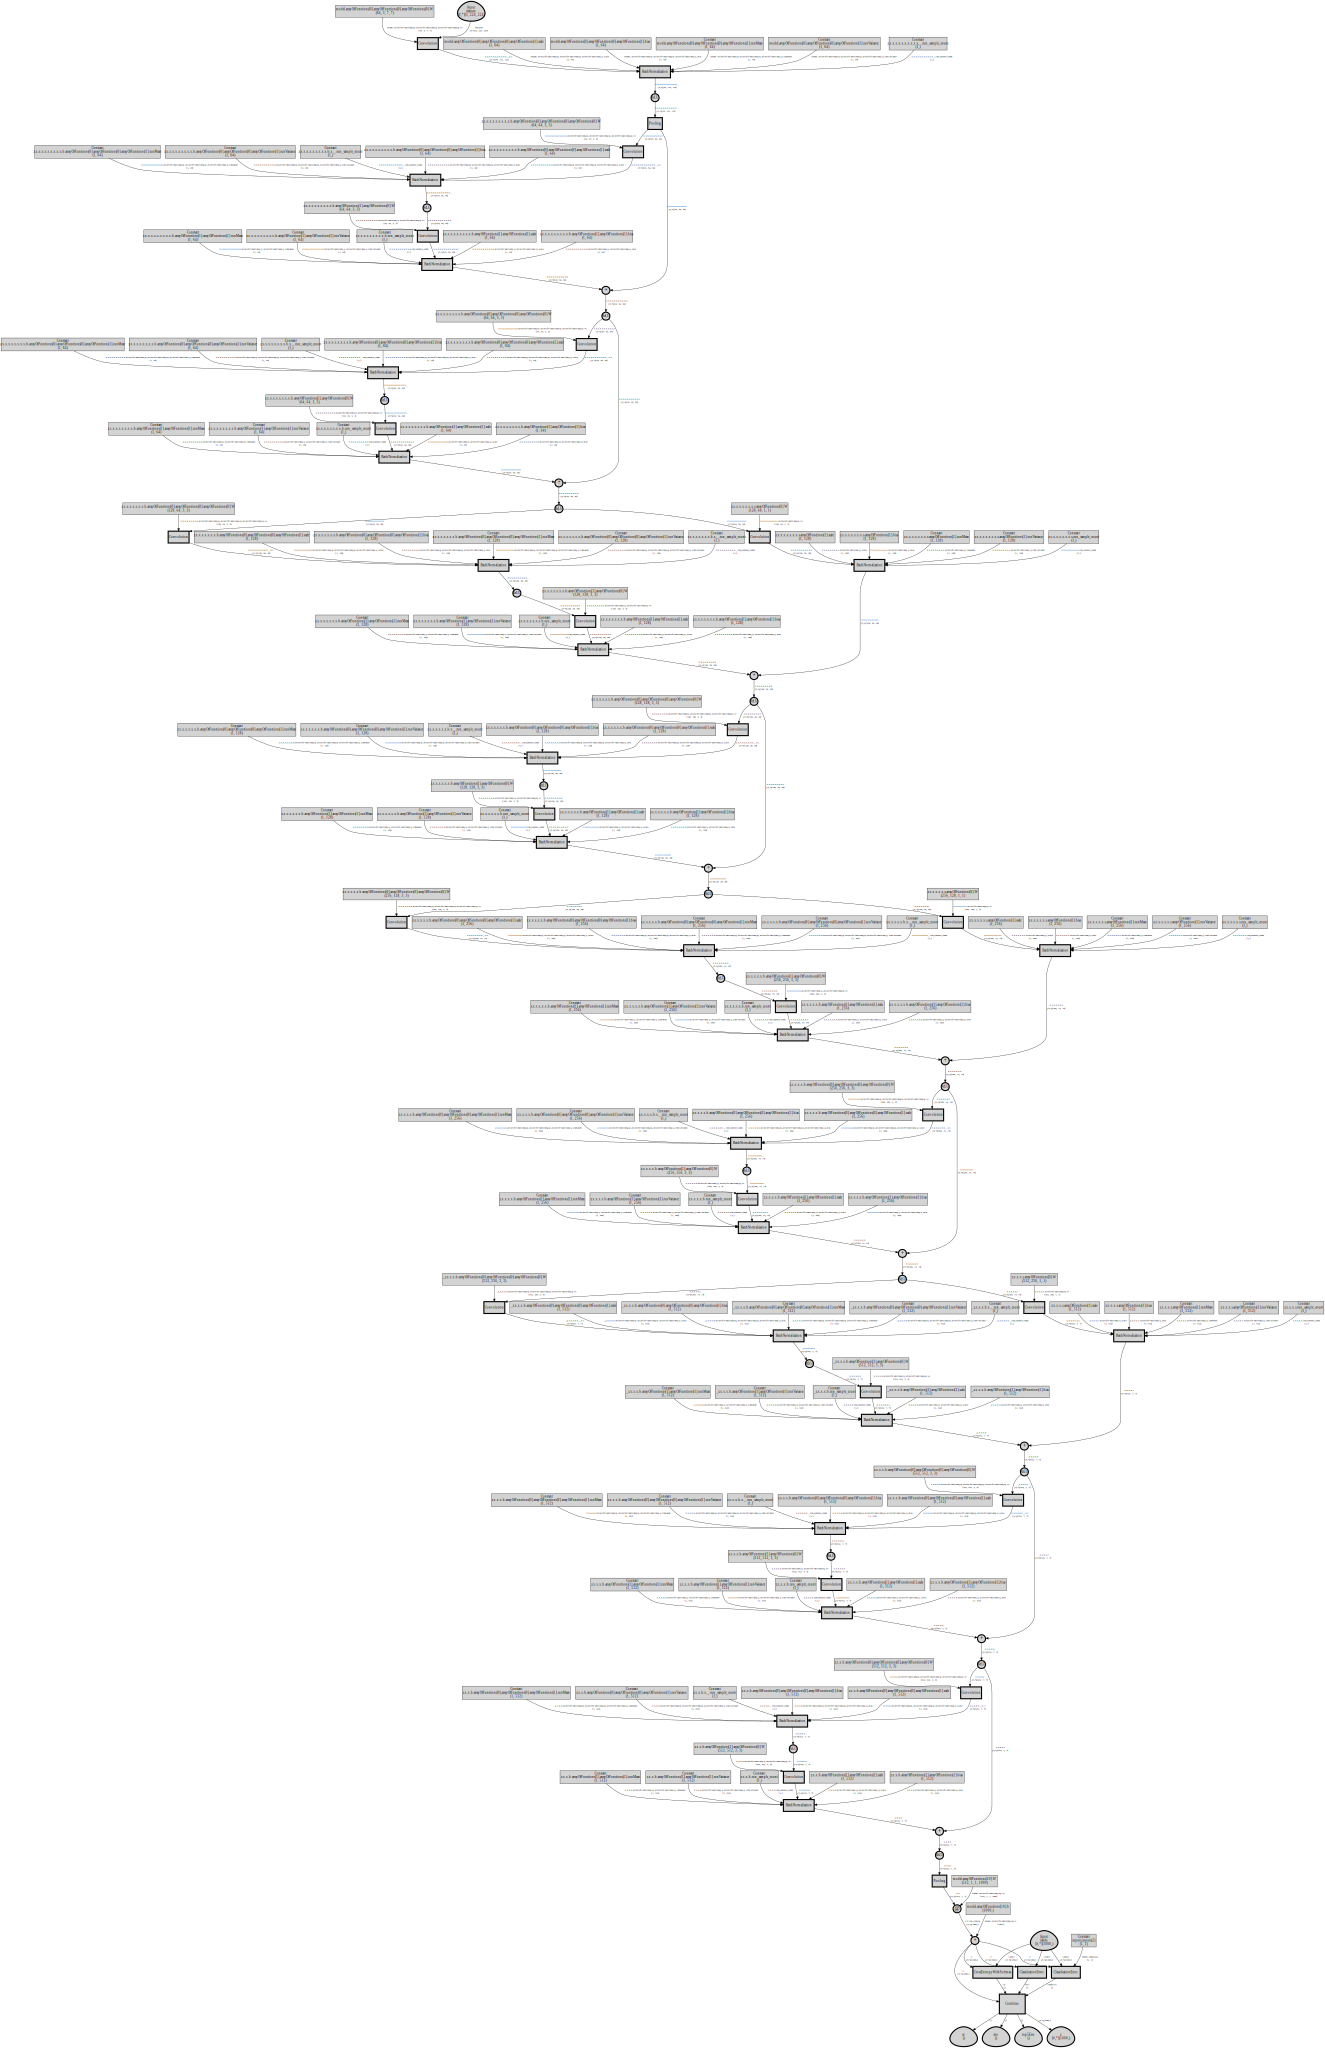

In [24]:
display(SVG(filename="tmp.svg"))

Visualizing the network architecture is tough due to it's complexity and size.
Kitties and puppies are simpler, and more fun to visualize!

In [25]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin = 0, vmax = 1.0, cmap = 'gray')
        ax.axis('off')
    plt.show()


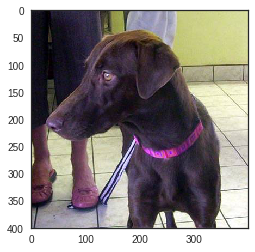

In [31]:
img = mpimg.imread(train_dogs[random.randint(0, len(train_dogs))])
plt.imshow(img)

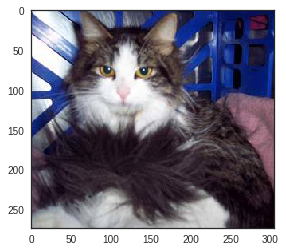

In [32]:
img = mpimg.imread(train_cats[random.randint(0, len(train_cats))])
plt.imshow(img)

In [33]:
def show_pics(paths: list):
    
    f, ax = plt.subplots(1, len(paths))
    
    for i, path in enumerate(paths):
        ax[i].imshow(Image.open(path))
        ax[i].set_title(os.path.basename(path))
        ax[i].axis('off')


In [34]:
dog_sample = train_dogs[0:3]
cat_sample = train_cats[0:3]

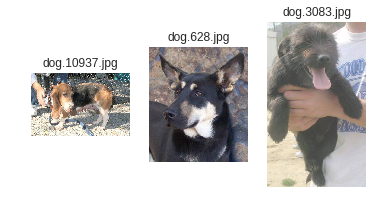

In [35]:
show_pics(dog_sample)

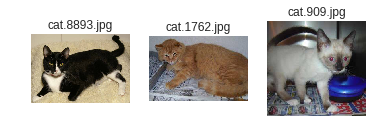

In [36]:
show_pics(cat_sample)

## Training the Transfer Model

Okay, back to our model. Let's take a look at those node labels again. The last labels are the cross-entropy term, errors, and top-5 errors. These are needed to define our full computational graph and for training through backpropagation. The last actual label is `z`, which maps to our class labels (1000 in this case, for the number of classes in [ImageNet](http://www.image-net.org/)). The last activation layer _prior_ to the dense mapping to ImageNet classes is `z.x`.

In [37]:
C.logging.get_node_outputs(C.load_model(base_model['model_file']))

[Output('ce', [], []),
 Output('errs', [], []),
 Output('top5Errs', [], []),
 Output('z', [#, ], [1000]),
 Output('ce', [], []),
 Output('z', [#, ], [1000]),
 Output('z.PlusArgs[0]', [#, ], [1000]),
 Output('z.x', [#, ], [512 x 1 x 1]),
 Output('z.x.x.r', [#, ], [512 x 7 x 7]),
 Output('z.x.x.p', [#, ], [512 x 7 x 7]),
 Output('z.x.x.b', [#, ], [512 x 7 x 7]),
 Output('z.x.x.b.x.c', [#, ], [512 x 7 x 7]),
 Output('z.x.x.b.x', [#, ], [512 x 7 x 7]),
 Output('z.x.x.b.x._', [#, ], [512 x 7 x 7]),
 Output('z.x.x.b.x._.x.c', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.r', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.p', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.b', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.b.x.c', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.b.x', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.b.x._', [#, ], [512 x 7 x 7]),
 Output('z.x.x.x.b.x._.x.c', [#, ], [512 x 7 x 7]),
 Output('_z.x.x.x.r', [#, ], [512 x 7 x 7]),
 Output('_z.x.x.x.p', [#, ], [512 x 7 x 7]),
 Output('_z.x.x.x.b', [#, ], [512 x

We clone the model so that we can re-use the same trained model multiple times, trained for different things - it is not strictly necessary if you are just training it for a single task, but this is why we would not use `CloneMethod.share`, we want to learn new parameters. If `freeze_weights` is true, we will freeze weights on all layers we clone and only learn weights on the final new features layer. This can often be useful if you are cloning higher up the tree (e.g., cloning after the first convolutional layer to just get basic image features).

We find the final hidden layer (`z.x`) using find_by_name, clone it and all of its predecessors, then attach a new `Dense` layer for classification.

In [38]:
def create_model(model_details, num_classes, input_features, 
                 new_prediction_node_name='prediction', freeze=False):
    base_model = C.load_model(model_details['model_file'])
    feature_node = C.logging.find_by_name(base_model, model_details['feature_node_name'])
    last_node = C.logging.find_by_name(base_model, model_details['last_hidden_node_name'])

    # Clone the desired layers with fixed weights
    cloned_layers = C.combine([last_node.owner]).clone(
        C.CloneMethod.freeze if freeze else C.CloneMethod.clone,
        {feature_node: C.placeholder(name='features')})

    # Add new dense layer for class prediction
    feat_norm = input_features
    cloned_out = cloned_layers(feat_norm)
    z = C.layers.Dense(num_classes, activation=None, name=new_prediction_node_name) (cloned_out)

    return z


## Define Minibatch Source
Now that we have our model defined, we have to also tell CNTK how to read in batches to train the model using backprop. Here we'll use the [`ImageDeserializer`](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.ImageDeserializer) class, designed specifically for the data we have here.

In [39]:
def create_mb_source(map_file, image_dims, num_classes, randomize=True):
    transforms = [xforms.scale(width=image_dims[2], height=image_dims[1], 
                               channels=image_dims[0], interpolations='linear')]
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
            features=C.io.StreamDef(field='image', transforms=transforms),
            labels=C.io.StreamDef(field='label', shape=num_classes))),
            randomize=randomize)

## Training
Now our setup is nearly complete. We have our network architecture defined, and our minibatch reader setup. The last step is defining the loss function for our optimization algorithm (in this case `binary_cross_entropy`, or `cross_entropy_softmax` if we had more than two classes). We'll use a specific learning routine with a momentum schedule, and simple $\ell_2$ regularization penalty on our model's weight terms.

In [40]:
def train_model(model_details, num_classes, train_map_file,
                learning_params, max_images=-1):
    num_epochs = learning_params['max_epochs']
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)
    minibatch_size = learning_params['mb_size']
    
    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, model_details['image_dims'], num_classes)
    image_input = C.input_variable(model_details['image_dims'])
    label_input = C.input_variable(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source['features'],
        label_input: minibatch_source['labels']
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(model_details, num_classes, image_input, freeze=learning_params['freeze_weights'])
    ce = C.binary_cross_entropy(tl_model, label_input)
    pe = C.classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = C.learning_rate_schedule(learning_params['lr_per_mb'], unit=C.UnitType.minibatch)
    mm_schedule = C.momentum_schedule(learning_params['momentum_per_mb'])
    learner = C.momentum_sgd(tl_model.parameters, lr_schedule, mm_schedule, 
                           l2_regularization_weight=learning_params['l2_reg_weight'])
    trainer = C.Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    C.logging.log_number_of_parameters(tl_model)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * minibatch_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model


In [41]:
force_retraining = True

max_training_epochs = 10

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.9,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}

In [42]:
kitty_doggo_model = {
    'model_file': os.path.join('DogsCats.model'),
    'results_file': os.path.join('predictions.txt'),
    'num_classes': 2
}

In [52]:
if os.path.isfile(kitty_doggo_model['model_file']):
    print("Reload stored model from %s", kitty_doggo_model['model_file'])
    trained_model = C.load_model(kitty_doggo_model['model_file'])
else:
    print("Retraining model and saving to %s", kitty_doggo_model['model_file'])
    trained_model = train_model(base_model,
                              kitty_doggo_model['num_classes'], 
                              base_model['training_map'],
                              learning_params)

Reload stored model from %s DogsCats.model


In [53]:
trained_model.save(kitty_doggo_model['model_file'])
print("Stored trained model at %s" % kitty_doggo_model['model_file'])

Stored trained model at DogsCats.model


In [54]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, image_dims):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image.open(image_path)

        if image_path.endswith("png"):
            temp = Image.new("RGB", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((image_dims[2], image_dims[1]), Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']

In [62]:
isFast = False # set to true if you want to evaluate fewer images

In [74]:
# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, 
                     image_dims, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isFast:
        num_images = min(num_images, 300) 

    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_dims)

                if probs[0]=='None':
                    print("Eval not possible: ", img_file)
                    continue

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1

                np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1:.2%} correct)".format(pred_count,
                                                                           (float(correct_count) / pred_count)))
                if pred_count >= num_images:
                    break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

In [56]:
%%bash
mkdir val/cats
mkdir val/dogs
mv val/cat.*.jpg ./val/cats/
mv val/dog.*.jpg ./val/dogs

In [75]:
class_mapping = create_class_mapping_from_folder(os.path.abspath(path="val/"))
testing_map = create_map_file_from_folder("val/", class_mapping)

In [76]:
kitty_doggo_model

{'model_file': 'DogsCats.model',
 'num_classes': 2,
 'results_file': 'predictions.txt'}

In [77]:
predict_correct, predict_total, predict_accuracy = \
   eval_test_images(trained_model, kitty_doggo_model['results_file'], 
                    testing_map, base_model['image_dims'])
print("Done. Wrote output to %s" % kitty_doggo_model['results_file'])


Evaluating model output node 'prediction' for 5000 images.
Processed 100 samples (97.00% correct)
Processed 200 samples (97.50% correct)
Processed 300 samples (98.33% correct)
Processed 400 samples (98.25% correct)
Processed 500 samples (98.20% correct)
Processed 600 samples (98.50% correct)
Processed 700 samples (98.57% correct)
Processed 800 samples (98.62% correct)
Processed 900 samples (98.22% correct)
Processed 1000 samples (98.40% correct)
Processed 1100 samples (98.27% correct)
Processed 1200 samples (98.00% correct)
Processed 1300 samples (98.08% correct)
Processed 1400 samples (98.07% correct)
Processed 1500 samples (98.07% correct)
Processed 1600 samples (98.00% correct)
Processed 1700 samples (98.06% correct)
Processed 1800 samples (98.06% correct)
Processed 1900 samples (98.05% correct)
Processed 2000 samples (97.95% correct)
Processed 2100 samples (97.90% correct)
Processed 2200 samples (97.86% correct)
Processed 2300 samples (97.91% correct)
Processed 2400 samples (97.83%

In [72]:
# evaluate test images
with open(testing_map, 'r') as input_file:
    head = list(itertools.islice(input_file, 15))
    for line in head:
        tokens = line.rstrip().split('\t')
        img_file = tokens[0]
        true_label = int(tokens[1])
        probs = eval_single_image(trained_model, img_file, base_model['image_dims'])

        if probs[0]=='None':
            continue
        class_probs = np.column_stack((probs, class_mapping)).tolist()
        class_probs.sort(key=lambda x: float(x[0]), reverse=True)
        predictions = ' '.join(['%s:%.3f' % (class_probs[i][1], float(class_probs[i][0])) \
                                for i in range(0, kitty_doggo_model['num_classes'])])
        true_class_name = class_mapping[true_label] if true_label >= 0 else 'unknown'
        print('Class: %s, predictions: %s, image: %s' % (true_class_name, predictions, img_file))


Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10001.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10003.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10005.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10006.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10010.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10016.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10017.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.1002.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10032.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10033.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.1004.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image: val/cats/cat.10047.jpg
Class: cats, predictions: cats:1.000 dogs:0.000, image

In [185]:
def predictions_df(results=kitty_doggo_model['results_file'], 
                   key_maps = "val/map.txt"):
    preds = pd.read_csv(results, sep=" ", names=['cat', 'dog'])
    maps_df = pd.read_csv(key_maps, names=['path', 'label'], sep='\t')
    preds = pd.concat([preds, maps_df], axis=1)
    
    return preds

In [186]:
preds = predictions_df()

In [187]:
preds.iloc[0:5]

,cat,dog,path,label
0,1.0,0.0,val/cats/cat.10001.jpg,0
1,1.0,0.0,val/cats/cat.10003.jpg,0
2,1.0,0.0,val/cats/cat.10005.jpg,0
3,1.0,0.0,val/cats/cat.10006.jpg,0
4,1.0,0.0,val/cats/cat.10010.jpg,0


In [196]:
def worst_preds(results = preds,
               kitties = 0):
    results = results[results['label'] == kitties]
    if kitties == 0:
        results = results.sort_values(by="cat", ascending=True)
    else:
        results = results.sort_values(by="dog", ascending=True)
    return results

In [197]:
worst_kitties = worst_preds(kitties = 0)
worst_pups = worst_preds(kitties = 1)

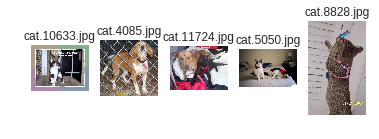

In [198]:
show_pics(worst_kitties['path'].iloc[0:5])

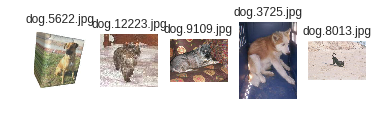

In [199]:
show_pics(worst_pups['path'].iloc[0:5])